# Bias Mitigation in AI Models for Cardiovascular Diseases Prediction

### Giorgia Castelli, Alice Fratini, Madalina Ionela Mone

We aim to detect and mitigate bias in a Cardiovascular Diseases Prediction pipeline.

We will first implement a simple predictive model for the binary classification of patients; we will then detect possible biases in the pipeline and implement different techniques for bias mitigation; finally, we will comment the results.

Among the metrics and bias mitigation techniques used, some belong to the  [Aequitas-Fairlib](https://pypi.org/project/aequitas-fairlib/) library.

## Imports

In [ ]:
%pip install pycaret

In [ ]:
%pip install aif360
%pip install fairlearn
%pip install BlackBoxAuditing
%pip install aequitas-fairlib

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from pycaret.classification  import setup, compare_models, evaluate_model, predict_model

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from fairlib import DataFrame
from fairlib.metrics import statistical_parity_difference, disparate_impact, equality_of_opportunity
from fairlearn.metrics import equalized_odds_ratio
from aif360.datasets import StandardDataset, BinaryLabelDataset

# Pre-processing algorithms
from fairlib.preprocessing import DisparateImpactRemover, Reweighing
from fairlib.preprocessing.lfr import LFR
from imblearn.over_sampling import SMOTE


# In-processing algorithms
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.sklearn.inprocessing import ExponentiatedGradientReduction
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

pip install 'aif360[inFairness]'


We are using the Heart Attack Prediction Dataset, available at https://www.kaggle.com/datasets/iamsouravbanerjee/heart-attack-prediction-dataset/data

## Data Loading

In [2]:
# Read the CSV file
file_path = r"heart_attack_prediction_dataset.csv"
df = pd.read_csv(file_path)

print("Length of the dataset:", len(df))
print("\n")
display(df.head())

Length of the dataset: 8763




,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [3]:
# The useless ID column is dropped
df = df.drop(['Patient ID'], axis=1)

## Data Exploration

In [4]:
# Summary Statistics
print("Summary Statistics:")
display(df.describe())
print("\n")

# Missing Values
print("\nMissing Values:")
display(df.isnull().sum())

Summary Statistics:


,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk
count,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000
mean,53.707977,259.877211,75.021682,0.652288,0.492982,0.896839,0.501426,0.598083,10.014284,0.495835,0.498345,5.469702,5.993690,158263.181901,28.891446,417.677051,3.489672,7.023508,0.358211
std,21.249509,80.863276,20.550948,0.476271,0.499979,0.304186,0.500026,0.490313,5.783745,0.500011,0.500026,2.859622,3.466359,80575.190806,6.319181,223.748137,2.282687,1.988473,0.479502
min,18.000000,120.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002442,0.000000,0.000000,1.000000,0.001263,20062.000000,18.002337,30.000000,0.000000,4.000000,0.000000
25%,35.000000,192.000000,57.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.981579,0.000000,0.000000,3.000000,2.998794,88310.000000,23.422985,225.500000,2.000000,5.000000,0.000000
50%,54.000000,259.000000,75.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.069559,0.000000,0.000000,5.000000,5.933622,157866.000000,28.768999,417.000000,3.000000,7.000000,0.000000
75%,72.000000,330.000000,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.050018,1.000000,1.000000,8.000000,9.019124,227749.000000,34.324594,612.000000,5.000000,9.000000,1.000000
max,90.000000,400.000000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.998709,1.000000,1.000000,10.000000,11.999313,299954.000000,39.997211,800.000000,7.000000,10.000000,1.000000





Missing Values:


,0
Age,0
Sex,0
Cholesterol,0
Blood Pressure,0
Heart Rate,0
Diabetes,0
Family History,0
Smoking,0
Obesity,0
Alcohol Consumption,0


We then split the Blood Pressure column into a Maximum and a Minimum column, for a more clean visualization and usage

In [5]:
# Split the 'Blood Pressure' column into 'Blood Pressure Maximum' and 'Blood Pressure Minimum'
df[['Blood Pressure Maximum', 'Blood Pressure Minimum']] = df['Blood Pressure'].str.split('/', expand=True)

df['Blood Pressure Maximum'] = pd.to_numeric(df['Blood Pressure Maximum'], downcast='integer')
df['Blood Pressure Minimum'] = pd.to_numeric(df['Blood Pressure Minimum'], downcast='integer')

df = df.drop(columns=['Blood Pressure'])

columns = [col for col in df.columns if col != 'Heart Attack Risk'] + ['Heart Attack Risk']
df = df[columns]

The distributions of potentially bias-inducing columns are visualized.

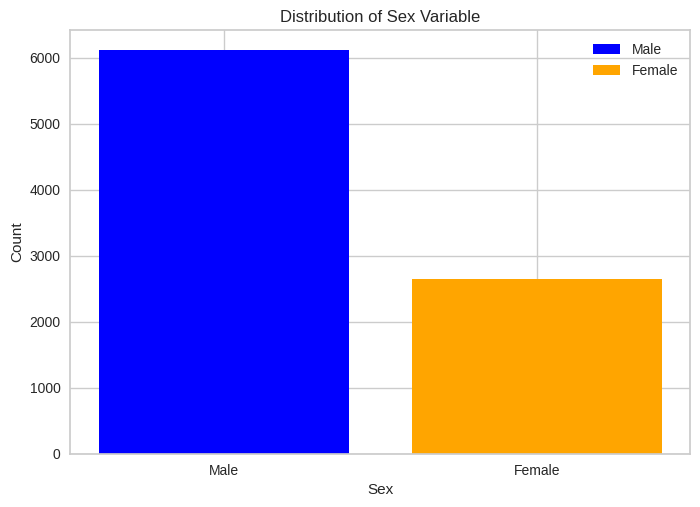

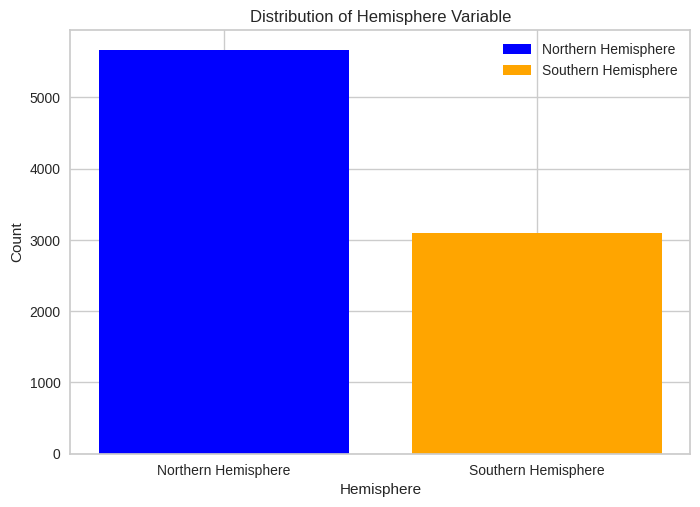

In [ ]:
# Plot the distribution of the 'Sex' variable
sex_counts = df['Sex'].value_counts()
bars = plt.bar(sex_counts.index, sex_counts.values, color=['blue', 'orange'])

plt.title('Distribution of Sex Variable')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(bars, ['Male', 'Female'])
plt.show()

# Plot the distribution of the 'Hemisphere' variable
hemisphere_counts = df['Hemisphere'].value_counts()
bars = plt.bar(hemisphere_counts.index, hemisphere_counts.values, color=['blue', 'orange'])

plt.title('Distribution of Hemisphere Variable')
plt.xlabel('Hemisphere')
plt.ylabel('Count')
plt.legend(bars, ['Northern Hemisphere', 'Southern Hemisphere'])
plt.show()

Suitable visualizations are exploited for the investigation of the other columns.

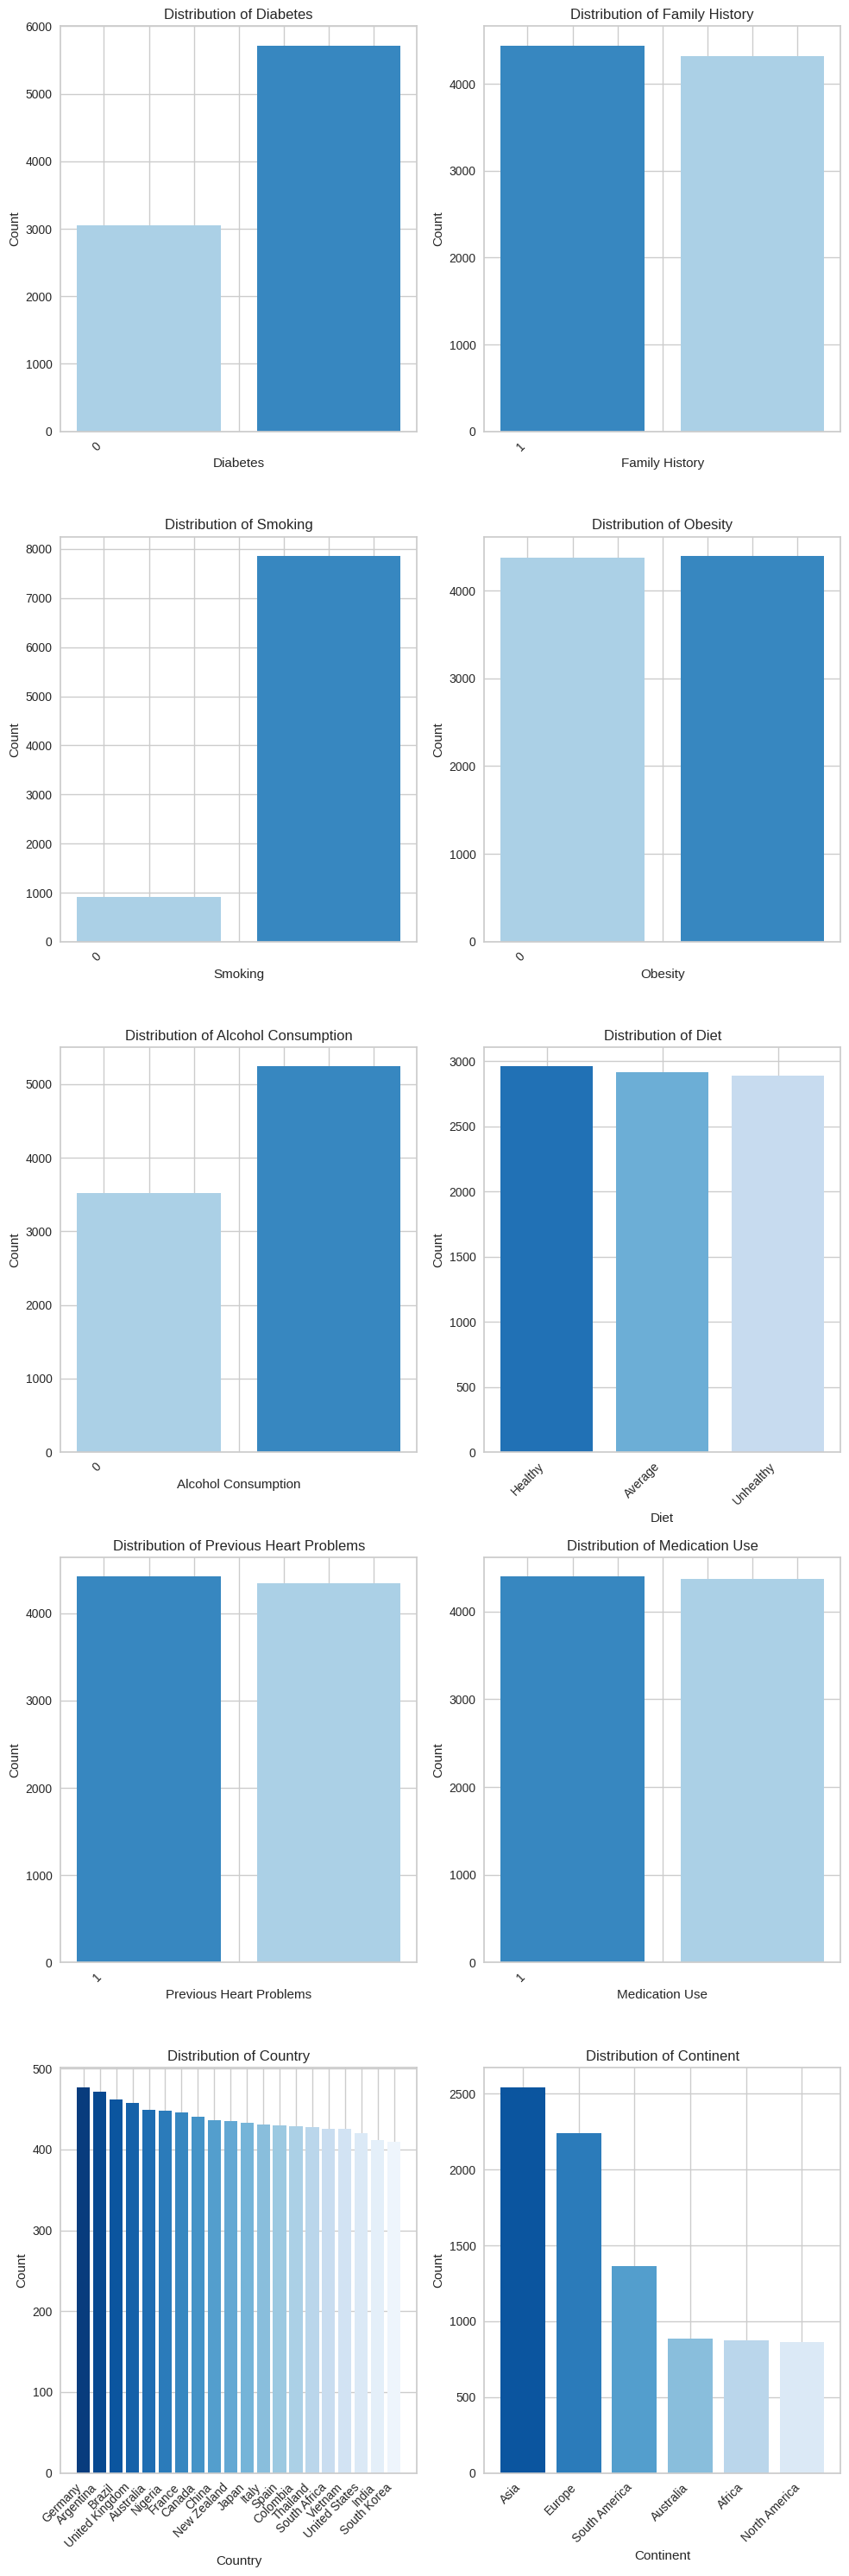

In [ ]:
def plot_distribution(df, columns):
    """
    Plots the distribution of specified columns in the df

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): The list of column names to plot the distribution for.
    """
    num_columns = len(columns)
    nrows = (num_columns + 1) // 2  # Calculate the number of rows needed
    ncols =  2 # Two columns
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 6 * nrows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for ax, column in zip(axes, columns):
        value_counts = df[column].value_counts()
        colors = sns.color_palette("Blues_r", len(value_counts))
        bars = ax.bar(value_counts.index, value_counts.values, color=colors)

        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.set_xticklabels(value_counts.index, rotation=45, ha='right')

    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

freq_columns = ['Sex', 'Income', 'Exercise Hours Per Week', 'Cholesterol', 'Age', 'Stress Level', 'Sedentary Hours Per Day', 'BMI', 'Triglycerides','Physical Activity Days Per Week', 'Blood Pressure Maximum', 'Blood Pressure Minimum', 'Heart Rate', 'Sleep Hours Per Day', 'Heart Attack Risk', 'Hemisphere' ]
distribution_columns = [col for col in df.columns if col not in freq_columns]
plot_distribution(df, distribution_columns)

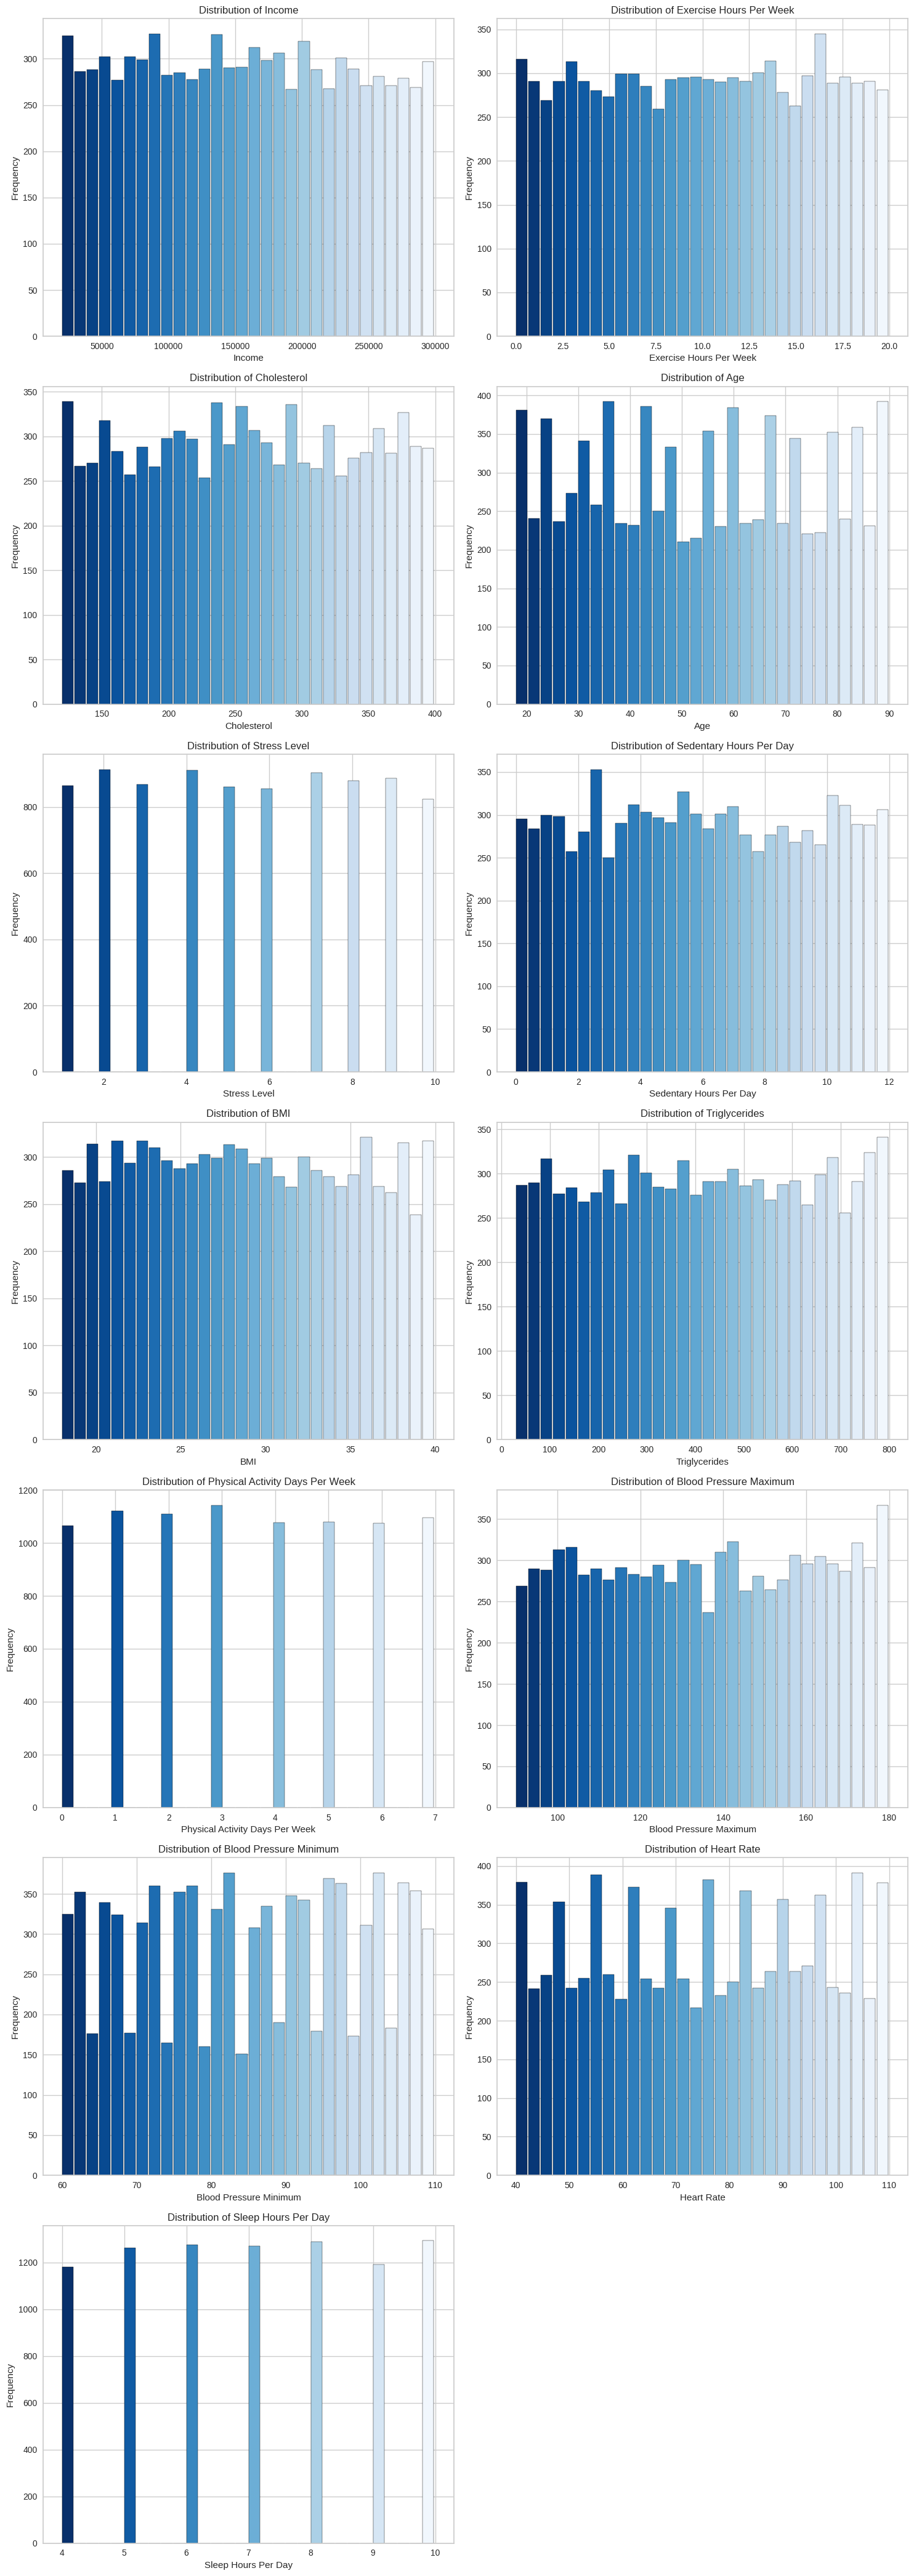

In [ ]:
def plot_histograms(df, columns):
    """
    Plots histograms of specified columns in the DataFrame in a grid layout with 2 columns per row.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): The list of column names to plot the histograms for.
    """
    numerical_columns = [col for col in columns if np.issubdtype(df[col].dtype, np.number)]

    num_columns = len(numerical_columns)
    nrows = (num_columns + 1) // 2
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6 * nrows))
    axes = axes.flatten()

    for ax, column in zip(axes, numerical_columns):
        n_bins = 30
        bin_width = (df[column].max() - df[column].min()) / n_bins
        counts, bins, patches = ax.hist(df[column], bins=n_bins, width=0.9 * bin_width, edgecolor='black')

        cmap = plt.get_cmap('Blues_r')
        for i in range(n_bins):
            patches[i].set_facecolor(cmap(i / n_bins))

        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    for i in range(len(numerical_columns), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

freq_columns_2 = ['Income', 'Exercise Hours Per Week', 'Cholesterol', 'Age', 'Stress Level', 'Sedentary Hours Per Day', 'BMI', 'Triglycerides','Physical Activity Days Per Week', 'Blood Pressure Maximum', 'Blood Pressure Minimum', 'Heart Rate', 'Sleep Hours Per Day']
columns_to_plot = freq_columns_2
plot_histograms(df, columns_to_plot)


A pie chart exhibits the distribution for the target column.

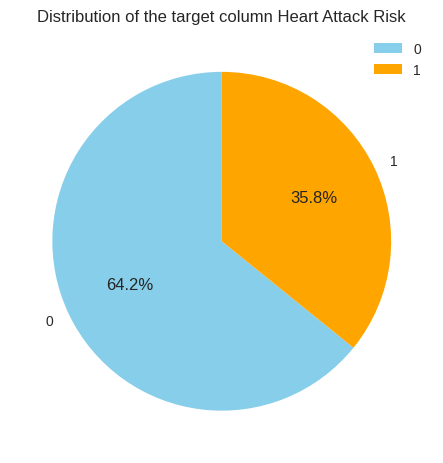

In [ ]:
# Plot pie chart for the target column
df['Heart Attack Risk'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title(f'Distribution of the target column Heart Attack Risk')
plt.ylabel('')
plt.legend(['0', '1']);

## Encoding of Categorical Variables

In [6]:
# Print the unique labels for each categorical column
categorical_columns = ['Sex', 'Diet', 'Hemisphere', 'Continent', 'Country']
categorical_labels = {}

for column in categorical_columns:
    unique_labels = df[column].unique()
    categorical_labels[column] = unique_labels

for column, labels in categorical_labels.items():
    print(f"Unique labels for {column}: {labels}")

Unique labels for Sex: ['Male' 'Female']
Unique labels for Diet: ['Average' 'Unhealthy' 'Healthy']
Unique labels for Hemisphere: ['Southern Hemisphere' 'Northern Hemisphere']
Unique labels for Continent: ['South America' 'North America' 'Europe' 'Asia' 'Africa' 'Australia']
Unique labels for Country: ['Argentina' 'Canada' 'France' 'Thailand' 'Germany' 'Japan' 'Brazil'
 'South Africa' 'United States' 'Vietnam' 'China' 'Italy' 'Spain' 'India'
 'Nigeria' 'New Zealand' 'South Korea' 'Australia' 'Colombia'
 'United Kingdom']


In [7]:
# Binary encoding for sensitive variables
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['Hemisphere'] = df['Hemisphere'].map({'Northern Hemisphere': 1, 'Southern Hemisphere': 0})

In [8]:
# Visualization of the remaining categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print(categorical_columns)

['Diet', 'Country', 'Continent']


In [9]:
# Encoding of the remaining categorical columns through LabelEncoder
label_encoders = {}
label_mappings = {}

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    label_mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

In [10]:
# Display the modified DataFrame
display(df.head())
print("\n")

# Display the label mappings
for column, mapping in label_mappings.items():
    print(f"Label mapping for {column}: {mapping}")

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Blood Pressure Maximum,Blood Pressure Minimum,Heart Attack Risk
0,67,1,208,72,0,0,1,0,0,4.168189,...,31.251233,286,0,6,0,5,0,158,88,0
1,21,1,389,98,1,1,1,1,1,1.813242,...,27.194973,235,1,7,3,4,1,165,93,0
2,21,0,324,72,1,0,0,0,0,2.078353,...,28.176571,587,4,4,6,3,1,174,99,0
3,84,1,383,73,1,1,1,0,1,9.828130,...,36.464704,378,3,4,3,4,1,163,100,0
4,66,1,318,93,1,1,1,1,0,5.804299,...,21.809144,231,1,5,16,1,1,91,88,0




Label mapping for Diet: {'Average': 0, 'Healthy': 1, 'Unhealthy': 2}
Label mapping for Country: {'Argentina': 0, 'Australia': 1, 'Brazil': 2, 'Canada': 3, 'China': 4, 'Colombia': 5, 'France': 6, 'Germany': 7, 'India': 8, 'Italy': 9, 'Japan': 10, 'New Zealand': 11, 'Nigeria': 12, 'South Africa': 13, 'South Korea': 14, 'Spain': 15, 'Thailand': 16, 'United Kingdom': 17, 'United States': 18, 'Vietnam': 19}
Label mapping for Continent: {'Africa': 0, 'Asia': 1, 'Australia': 2, 'Europe': 3, 'North America': 4, 'South America': 5}


## Numerical Columns Normalization
All numerical columns, except for binary and target columns, are normalized exploiting MinMaxScaler().

In [11]:
scaler = MinMaxScaler()

binary_cols = [col for col in df.columns if df[col].nunique() == 2]

numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in binary_cols]

print(binary_cols)
print(numerical_cols)

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.head()

['Sex', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems', 'Medication Use', 'Hemisphere', 'Heart Attack Risk']
['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Diet', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent']


,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Blood Pressure Maximum,Blood Pressure Minimum,Heart Attack Risk
0,0.680556,1,0.314286,0.457143,0,0,1,0,0,0.208326,...,0.602363,0.332468,0.000000,0.333333,0.000000,1.0,0,158,88,0
1,0.041667,1,0.960714,0.828571,1,1,1,1,1,0.090557,...,0.417945,0.266234,0.142857,0.500000,0.157895,0.8,1,165,93,0
2,0.041667,0,0.728571,0.457143,1,0,0,0,0,0.103815,...,0.462573,0.723377,0.571429,0.000000,0.315789,0.6,1,174,99,0
3,0.916667,1,0.939286,0.471429,1,1,1,0,1,0.491376,...,0.839394,0.451948,0.428571,0.000000,0.157895,0.8,1,163,100,0
4,0.666667,1,0.707143,0.757143,1,1,1,1,0,0.290147,...,0.173077,0.261039,0.142857,0.166667,0.842105,0.2,1,91,88,0


## Train-Test Splitting

In [12]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
test_size = int(0.2 * len(df_shuffled))
test_df = df_shuffled[:test_size]
train_df = df_shuffled[test_size:]

# Print the length of such datasets
print("Length of the training set:", len(train_df))
print("\nLength of the test set:", len(test_df))

Length of the training set: 7011

Length of the test set: 1752


## Conversion to a Fairlib DataFrame

A Fairlib constructor is used: the output DataFrame is compatible with all the methods in the library.

In [15]:
df_fairlib = DataFrame(df)
train_df_fairlib = DataFrame(train_df)
test_df_fairlib = DataFrame(test_df)

df_fairlib.sensitive = ['Sex', 'Hemisphere']
train_df_fairlib.sensitive = ['Sex', 'Hemisphere']
test_df_fairlib.sensitive = ['Sex', 'Hemisphere']
df_fairlib.targets = 'Heart Attack Risk'
train_df_fairlib.targets = 'Heart Attack Risk'
test_df_fairlib.targets = 'Heart Attack Risk'

## Model Creation

The PyCaret setup is exploited for the definition of a binary classification model.

In [ ]:
# Initialize the PyCaret setup
clf = setup(data=train_df_fairlib, target='Heart Attack Risk', session_id=42, verbose=False)

# Compare models and select the best one
best_model = compare_models(sort='precision')

print('\nThe best model found is:')
print(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.6144,0.5175,0.1560,0.4022,0.2242,0.0303,0.0365,0.0290
ada,Ada Boost Classifier,0.6332,0.5190,0.0370,0.3883,0.0671,0.0034,0.0091,0.2830
xgboost,Extreme Gradient Boosting,0.5883,0.5137,0.2243,0.3731,0.2793,0.0169,0.0176,0.2690
lightgbm,Light Gradient Boosting Machine,0.6100,0.5118,0.1213,0.3657,0.1818,0.0045,0.0057,0.5710
dt,Decision Tree Classifier,0.5364,0.5019,0.3802,0.3600,0.3694,0.0036,0.0036,0.0770
knn,K Neighbors Classifier,0.5712,0.4822,0.2321,0.3490,0.2785,-0.0084,-0.0092,0.0620
et,Extra Trees Classifier,0.6336,0.4957,0.0273,0.3456,0.0504,-0.0012,-0.0034,0.6570
gbc,Gradient Boosting Classifier,0.6320,0.5121,0.0302,0.3407,0.0550,-0.0028,-0.0061,1.1870
rf,Random Forest Classifier,0.6317,0.5066,0.0290,0.3293,0.0532,-0.0039,-0.0095,1.0500
svm,SVM - Linear Kernel,0.4253,0.5014,0.7545,0.2849,0.4119,-0.0033,-0.0019,0.0730


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


The best model found is:
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


In [ ]:
# Evaluate the best model
evaluate_model(best_model)

predictions = predict_model(best_model, data=test_df)
y_true = test_df['Heart Attack Risk']
y_pred_pc = predictions['prediction_label']

print(classification_report(y_true, y_pred_pc))

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.6084,0.4992,0.1338,0.3717,0.1967,0.0086,0.0106


              precision    recall  f1-score   support

           0       0.64      0.87      0.74      1124
           1       0.37      0.13      0.20       628

    accuracy                           0.61      1752
   macro avg       0.51      0.50      0.47      1752
weighted avg       0.55      0.61      0.55      1752



In [ ]:
# Convert the output into a fairlib DataFrame
predictions_fairlib = DataFrame(predictions)
predictions_fairlib.sensitive = ['Sex', 'Hemisphere']
predictions_fairlib.targets = 'Heart Attack Risk'

## Bias Detection

The baseline fairness metrics are evaluated using the available fairlib.metrics methods. The equalized_odds_ratio function from Fairlearn is also exploited.

In [ ]:
disparate_impact = predictions_fairlib.disparate_impact()
print("Disparate Impact Metrics:\n")
for i in disparate_impact.keys():
    print(f'{i}: {disparate_impact[i]}')

equality_of_opportunity = predictions_fairlib.equality_of_opportunity(predictions_fairlib['prediction_label'])
print("\n\nEquality of Opportunity Metrics:\n")
for i in equality_of_opportunity.keys():
    print(f'{i}: {equality_of_opportunity[i]}')

stat_parity_difference = predictions_fairlib.statistical_parity_difference()
print("\n\nStatistical Parity Difference Metrics:\n")
for i in stat_parity_difference.keys():
    print(f'{i}: {stat_parity_difference[i]}')

equ_odds_ratio = equalized_odds_ratio(y_true = predictions_fairlib["Heart Attack Risk"], y_pred=predictions_fairlib["prediction_label"], sensitive_features=predictions_fairlib[['Sex', 'Hemisphere']])
print("\n\nEqualized Odds Ratio: ",{equ_odds_ratio})


Disparate Impact Metrics:

(Heart Attack Risk=0, Sex=0): 0.9955771407016221
(Heart Attack Risk=0, Sex=1): 1.0044425078856882
(Heart Attack Risk=1, Sex=0): 1.0079838280668156
(Heart Attack Risk=1, Sex=1): 0.9920794085733224
(Heart Attack Risk=0, Hemisphere=0): 0.9971149710504549
(Heart Attack Risk=0, Hemisphere=1): 1.002893376424291
(Heart Attack Risk=1, Hemisphere=0): 1.0051904761904762
(Heart Attack Risk=1, Hemisphere=1): 0.994836325737837


Equality of Opportunity Metrics:

(Heart Attack Risk=1, Sex=0): 0.05819861431870671
(Heart Attack Risk=1, Sex=1): -0.05819861431870671
(Heart Attack Risk=1, Hemisphere=0): -0.08751768033946256
(Heart Attack Risk=1, Hemisphere=1): 0.08751768033946256


Statistical Parity Difference Metrics:

(Heart Attack Risk=0, Sex=0): 0.0028461544296691788
(Heart Attack Risk=0, Sex=1): -0.0028461544296691788
(Heart Attack Risk=1, Sex=0): -0.0028461544296691788
(Heart Attack Risk=1, Sex=1): 0.0028461544296691788
(Heart Attack Risk=0, Hemisphere=0): 0.001854332801

## Bias Mitigation

In this section, a wide range of bias-reducing techniques are tested on the dataset and algorithms. See https://arxiv.org/pdf/2207.07068 and https://arxiv.org/pdf/2305.20020 for a comprehensive review of state-of-art algorithms in this field.

### **PRE-PROCESSING TECHNIQUES**

Algorithms that deal with bias mitigation through the direct manipulation of training data, before the modelling step.

Different manipulated DataFrames are created exploiting common pre-processing techniques; then, the PyCaret selected best_model is invoked on them and performance metrics are calculated again; finally, fairness metrics are calculated.

1. DISPARATE IMPACT REMOVER: fairlib.preprocessing.disparate_impact_remover is used to perturbate the DataFrame in order to get the distributions of privileged and unprivileged groups closer; the preservation of rank-ordering within groups is also taken into account. A wrapper is defined starting from the original method, enabling intersectionality.

In [33]:
class IntersectionalDisparateImpactRemover:
    def __init__(self, repair_level=1.0, drop_intersection_col=True):
        self.repair_level = repair_level
        self.dir_remover = DisparateImpactRemover(repair_level=self.repair_level)
        self.intersection_col = "_intersectional_sensitive"
        self.original_sensitive = None
        self.drop_intersection_col = drop_intersection_col

    def _create_intersection_column(self, df):
        # Create intersectional column
        self.original_sensitive = list(df.sensitive)

        if len(self.original_sensitive) == 1:
            return df, self.original_sensitive[0]

        df[self.intersection_col] = df[self.original_sensitive].astype(str).agg('_'.join, axis=1).astype('category').cat.codes
        df.sensitive = [self.intersection_col]

        return df, self.intersection_col

    def _restore_sensitive_columns(self, df_out, df_original):
        # Restore original values for sensitive and target columns
        for col in self.original_sensitive:
            df_out[col] = df_original[col].values

        df_out.sensitive = set(self.original_sensitive)

        target_col = list(df_original.targets)[0] if isinstance(df_original.targets, set) else df_original.targets
        df_out[target_col] = df_original[target_col].values
        df_out.targets = target_col

        if self.drop_intersection_col and self.intersection_col in df_out.columns:
            df_out.drop(columns=[self.intersection_col], inplace=True)

        return df_out

    def fit_transform(self, df):
        df_copy = df.copy()
        df_prepared, _ = self._create_intersection_column(df_copy)
        df_transformed = self.dir_remover.fit_transform(df_prepared)
        return self._restore_sensitive_columns(df_transformed, df)

    def transform(self, df):
        df_copy = df.copy()
        df_prepared, _ = self._create_intersection_column(df_copy)
        df_transformed = self.dir_remover.transform(df_prepared)
        return self._restore_sensitive_columns(df_transformed, df)

In [34]:
inter_remover = IntersectionalDisparateImpactRemover(repair_level=1.0)

exp_1_df = inter_remover.fit_transform(df_fairlib)

print(exp_1_df.head())

        Age  Sex  Cholesterol  Heart Rate  Diabetes  Family History  Smoking  \
0  0.688850    1     0.316732    0.466212  0.853105        0.619432      1.0   
1  0.041667    1     0.952475    0.833689  1.000000        1.000000      1.0   
2  0.055556    0     0.717014    0.459485  1.000000        0.232865      1.0   
3  0.919569    1     0.934244    0.485714  1.000000        1.000000      1.0   
4  0.666667    1     0.704238    0.768017  1.000000        1.000000      1.0   

    Obesity  Alcohol Consumption  Exercise Hours Per Week  ...       BMI  \
0  1.000000             1.000000                 0.214612  ...  0.598211   
1  1.000000             1.000000                 0.093454  ...  0.415907   
2  0.276508             0.726421                 0.101166  ...  0.462898   
3  0.000000             1.000000                 0.488121  ...  0.842307   
4  1.000000             0.000000                 0.289648  ...  0.182874   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours

2. LEARNING FAIR REPRESENTATIONS (LFR): fairlib.preprocessing.lfr.LFR is used to learn a latent representation that encodes the data properly, while covering information about the protected attribute.

In [ ]:
class IntersectionalLFR:
    def __init__(self, latent_dim=8, alpha_z=1.0, alpha_x=1.0, alpha_y=1.0,
                 epochs=50, batch_size=64, drop_intersection_col=True):
        self.latent_dim = latent_dim
        self.alpha_z = alpha_z
        self.alpha_x = alpha_x
        self.alpha_y = alpha_y
        self.epochs = epochs
        self.batch_size = batch_size
        self.drop_intersection_col = drop_intersection_col

        self.model = None
        self.intersection_col = "_intersectional_sensitive"
        self.original_sensitive = None

    def _create_intersection_column(self, df):
        # Create intersectional column
        self.original_sensitive = list(df.sensitive)

        if len(self.original_sensitive) == 1:
            return df, self.original_sensitive[0]

        df[self.intersection_col] = df[self.original_sensitive].astype(str).agg('_'.join, axis=1).astype('category').cat.codes
        df.sensitive = [self.intersection_col]
        return df, self.intersection_col

    def _restore_sensitive_columns(self, df_out, df_original):
        # Restore original values for sensitive and target columns
        for col in self.original_sensitive:
            df_out[col] = df_original[col].values

        df_out.sensitive = self.original_sensitive

        target_col = list(df_original.targets)[0] if isinstance(df_original.targets, set) else df_original.targets
        df_out[target_col] = df_original[target_col].values
        df_out.targets = target_col

        if self.drop_intersection_col and self.intersection_col in df_out.columns:
            df_out.drop(columns=[self.intersection_col], inplace=True)

        return df_out

    def fit_transform(self, df):
        df_copy = df.copy()
        df_prepared, _ = self._create_intersection_column(df_copy)

        sensitive_cols = list(df_prepared.sensitive)
        target_col = df_prepared.targets
        feature_cols = [col for col in df_prepared.columns if col not in sensitive_cols + [target_col]]
        input_dim = len(feature_cols)
        output_dim = input_dim

        self.model = LFR(
            input_dim=input_dim,
            latent_dim=self.latent_dim,
            output_dim=output_dim,
            alpha_z=self.alpha_z,
            alpha_x=self.alpha_x,
            alpha_y=self.alpha_y,
        )

        self.model.fit(df_prepared, epochs=self.epochs, batch_size=self.batch_size)
        df_transformed = self.model.transform(df_prepared)

        return self._restore_sensitive_columns(df_transformed, df)

    def transform(self, df):
        if self.model is None:
            raise ValueError("The model must be fit before calling transform.")

        df_copy = df.copy()
        df_prepared, _ = self._create_intersection_column(df_copy)
        df_transformed = self.model.transform(df_prepared)

        return self._restore_sensitive_columns(df_transformed, df)


In [ ]:
lfr_wrapper = IntersectionalLFR(
    latent_dim=8,
    alpha_z=1.0,
    alpha_x=1.0,
    alpha_y=1.0,
    epochs=50,
    batch_size=64
)

exp_2_df = lfr_wrapper.fit_transform(df_fairlib)

print(exp_2_df.head())

         z0        z1        z2        z3        z4        z5        z6  \
0 -0.223925 -0.569247  0.195503 -0.894484 -0.786039 -0.462959  0.004018   
1 -0.201343 -0.443703  0.449276 -0.973332 -0.721412 -0.464186  0.177747   
2  0.582445  0.229009  0.507810 -0.444780 -0.577532 -1.444181  0.367046   
3 -0.219719 -0.286396  0.499307 -1.024752 -0.674853 -0.326984 -0.309014   
4 -0.334716 -0.526494  0.522126 -1.045986 -0.780052 -0.423171 -0.002645   

         z7  Sex  Hemisphere  Heart Attack Risk  
0  0.913279    1           0                  0  
1  0.764705    1           1                  0  
2  0.242497    0           1                  0  
3  1.234775    1           1                  0  
4  0.848529    1           1                  0  


3. REWEIGHING: fairlib.preprocessing.Reweighing is used to ensure fairness with respect to the protected attribute by assigning proper weights to the instances. In this case, a wrapper is not needed, since Reweighing function natively guarantees intersectionality. Since PyCaret does not support weighting, the weights are used for oversampling.

In [ ]:
reweighing = Reweighing()
reweighed_df = reweighing.fit_transform(df_fairlib)

# Oversample the dataset based on weights
oversampled_df = reweighed_df.loc[reweighed_df.index.repeat(reweighed_df['weights'].round().astype(int))].reset_index(drop=True)
exp_3_df = oversampled_df.drop(columns=['weights'])

print(exp_3_df.head())

        Age  Sex  Cholesterol  Heart Rate  Diabetes  Family History  Smoking  \
0  0.680556    1     0.314286    0.457143         0               0        1   
1  0.041667    1     0.960714    0.828571         1               1        1   
2  0.041667    0     0.728571    0.457143         1               0        0   
3  0.916667    1     0.939286    0.471429         1               1        1   
4  0.666667    1     0.707143    0.757143         1               1        1   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  ...       BMI  \
0        0                    0                 0.208326  ...  0.602363   
1        1                    1                 0.090557  ...  0.417945   
2        0                    0                 0.103815  ...  0.462573   
3        0                    1                 0.491376  ...  0.839394   
4        1                    0                 0.290147  ...  0.173077   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per D

4. PERTURBATION: perturbs each non-protected attribute (modifies its label) ensuring that its distribution is brought closer together while preserving the ranks within each group. Intersectionality is taken into account in a similar way as in the first two experiments.

In [ ]:
target_column = 'Heart Attack Risk'
protected_attributes = ['Sex', 'Hemisphere']
non_protected_columns = [col for col in df.columns if col not in protected_attributes + [target_column]]

# Create intersectional column
df['_intersectional_sensitive'] = (
    df[protected_attributes].astype(str)
    .agg('_'.join, axis=1)
    .astype('category').cat.codes
)

# Pertutbation for each intersectional group
perturbed_groups = []

for group_code in df['_intersectional_sensitive'].unique():
    group_df = df[df['_intersectional_sensitive'] == group_code].copy()

    for col in non_protected_columns:
        # Rank and normalization
        ranks = group_df[col].rank(method="first")
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(group_df[[col]])

        # Reorder according to normalized rank
        sorted_idx = np.argsort(scaled.flatten())
        sorted_values = np.sort(group_df[col].values)

        # Reassign ordered values to ordered records
        group_df.iloc[sorted_idx, group_df.columns.get_loc(col)] = sorted_values

    perturbed_groups.append(group_df)

exp_4_df = pd.concat(perturbed_groups, ignore_index=True)
exp_4_df.drop(columns=['_intersectional_sensitive'], inplace=True)

print(exp_4_df.head())

        Age  Sex  Cholesterol  Heart Rate  Diabetes  Family History  Smoking  \
0  0.680556    1     0.314286    0.457143         0               0        1   
1  0.027778    1     0.089286    0.400000         1               0        1   
2  0.763889    1     0.007143    0.814286         1               1        1   
3  0.708333    1     0.925000    0.000000         1               1        1   
4  0.444444    1     0.853571    0.814286         0               1        1   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  ...       BMI  \
0        0                    0                 0.208326  ...  0.602363   
1        1                    0                 0.843450  ...  0.809623   
2        0                    1                 0.727997  ...  0.842108   
3        1                    1                 0.209149  ...  0.469674   
4        0                    1                 0.417676  ...  0.756938   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per D

5. DOWNSAMPLING: reduces the number of instances to the size of the smallest group. Intersectionality is supported in a similar fashion as above.

In [32]:
# Find group having minimum size
group_counts = df['_intersectional_sensitive'].value_counts()
min_group_size = group_counts.min()

# Downsample of each intersectional group
downsampled_groups = []

for group_code in group_counts.index:
    group_df = df[df['_intersectional_sensitive'] == group_code]
    downsampled = group_df.sample(n=min_group_size, random_state=42)
    downsampled_groups.append(downsampled)

exp_5_df = pd.concat(downsampled_groups, ignore_index=True)
exp_5_df = exp_5_df.sample(frac=1, random_state=42).reset_index(drop=True)
exp_5_df.drop(columns=['_intersectional_sensitive'], inplace=True)

print(exp_5_df.head())

        Age  Sex  Cholesterol  Heart Rate  Diabetes  Family History  Smoking  \
0  0.847222    1     0.067857    0.528571         1               0        1   
1  0.569444    0     0.628571    0.057143         0               1        1   
2  0.222222    1     0.557143    0.485714         1               1        1   
3  0.666667    0     0.267857    0.414286         1               1        1   
4  0.763889    1     0.003571    0.528571         1               1        1   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  ...       BMI  \
0        0                    0                 0.914421  ...  0.688907   
1        1                    1                 0.691736  ...  0.840684   
2        0                    1                 0.006697  ...  0.490735   
3        0                    1                 0.259597  ...  0.697324   
4        0                    0                 0.990910  ...  0.253816   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per D

6. UPSAMPLING - SMOTE ALGORITHM: generates synthetic elements by interpolating between a random row and one of its k-nearest neighbours. Intersectionality is taken into account in a similar way as in the above experiments.

In [21]:
X = df.drop(columns=['_intersectional_sensitive'])
y = df['_intersectional_sensitive']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

exp_6_df = X_resampled.copy()
exp_6_df['_intersectional_sensitive'] = y_resampled

exp_6_df.drop(columns=['_intersectional_sensitive'], inplace=True)

print(exp_6_df.head())

        Age  Sex  Cholesterol  Heart Rate  Diabetes  Family History  Smoking  \
0  0.680556    1     0.314286    0.457143         0               0        1   
1  0.041667    1     0.960714    0.828571         1               1        1   
2  0.041667    0     0.728571    0.457143         1               0        0   
3  0.916667    1     0.939286    0.471429         1               1        1   
4  0.666667    1     0.707143    0.757143         1               1        1   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  ...       BMI  \
0        0                    0                 0.208326  ...  0.602363   
1        1                    1                 0.090557  ...  0.417945   
2        0                    0                 0.103815  ...  0.462573   
3        0                    1                 0.491376  ...  0.839394   
4        1                    0                 0.290147  ...  0.173077   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per D

A function is now defined, setupping PyCaret for each pre-processed DataFrame, repeating the training and evaluation steps for the best model selected and calculating the fairness metrics for the DataFrame.

In [22]:
def bias_mitigation_analysis(df, experiment_number):

  print(f'BIAS MITIGATION ANALYSIS - EXPERIMENT NUMBER {experiment_number}:')

  # Split the dataset into training and test sets
  df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
  test_size = int(0.2 * len(df_shuffled))
  test_df = df_shuffled[:test_size]
  train_df = df_shuffled[test_size:]

  # Model selection using PyCaret
  clf = setup(data=train_df, target='Heart Attack Risk', session_id=42, verbose=False)

  print('\nMODEL SELECTION USING PYCARET:')
  print('\n')

  best_model = compare_models(sort='precision')

  print('\nThe best model found is:')
  print(best_model)
  print('\n')

  # Evaluation and prediction using selected model
  evaluate_model(best_model)

  predictions = predict_model(best_model, data=test_df)
  y_true = test_df['Heart Attack Risk']
  y_pred_pc = predictions['prediction_label']

  print(classification_report(y_true, y_pred_pc))

  print('\nBIAS EVALUATION STEP:')
  print('\n')

  # Convert the output into a fairlib DataFrame
  predictions_fairlib = DataFrame(predictions)
  predictions_fairlib.sensitive = ['Sex', 'Hemisphere']
  predictions_fairlib.targets = 'Heart Attack Risk'

  # Get fairness metrics for the output DataFrame
  disparate_impact = predictions_fairlib.disparate_impact()
  print("Disparate Impact Metrics:\n")
  for i in disparate_impact.keys():
      print(f'{i}: {disparate_impact[i]}')

  equality_of_opportunity = predictions_fairlib.equality_of_opportunity(predictions_fairlib['prediction_label'])
  print("\n\nEquality of Opportunity Metrics:\n")
  for i in equality_of_opportunity.keys():
      print(f'{i}: {equality_of_opportunity[i]}')

  stat_parity_difference = predictions_fairlib.statistical_parity_difference()
  print("\n\nStatistical Parity Difference Metrics:\n")
  for i in stat_parity_difference.keys():
      print(f'{i}: {stat_parity_difference[i]}')

  equ_odds_ratio = equalized_odds_ratio(y_true = predictions_fairlib["Heart Attack Risk"], y_pred=predictions_fairlib["prediction_label"], sensitive_features=predictions_fairlib[['Sex', 'Hemisphere']])
  print("\n\nEqualized Odds Ratio: ",{equ_odds_ratio})




The function will now be applied on the pre-processed datasets.


In [35]:
# Call the function on Experiment 1's DataFrame
bias_mitigation_analysis(exp_1_df, 1)

BIAS MITIGATION ANALYSIS - EXPERIMENT NUMBER 1:

MODEL SELECTION USING PYCARET:




,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6148,0.5171,0.1309,0.3932,0.1959,0.0186,0.0248,0.4060
qda,Quadratic Discriminant Analysis,0.6055,0.5143,0.1724,0.3860,0.2381,0.0221,0.0254,0.0310
rf,Random Forest Classifier,0.6350,0.5134,0.0342,0.3823,0.0625,0.0054,0.0104,1.2270
ada,Ada Boost Classifier,0.6301,0.5122,0.0506,0.3687,0.0887,0.0048,0.0070,0.4350
xgboost,Extreme Gradient Boosting,0.5863,0.5098,0.2140,0.3664,0.2699,0.0087,0.0093,0.4020
et,Extra Trees Classifier,0.6316,0.4993,0.0359,0.3595,0.0651,-0.0004,-0.0001,0.6110
dt,Decision Tree Classifier,0.5309,0.4954,0.3705,0.3526,0.3611,-0.0090,-0.0091,0.0950
knn,K Neighbors Classifier,0.5673,0.4917,0.2430,0.3499,0.2865,-0.0094,-0.0097,0.0680
gbc,Gradient Boosting Classifier,0.6315,0.5196,0.0330,0.3306,0.0597,-0.0020,-0.0071,1.3770
svm,SVM - Linear Kernel,0.4817,0.5017,0.5676,0.2485,0.3122,0.0011,0.0034,0.0900


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


The best model found is:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)




interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6187,0.5335,0.1194,0.3947,0.1834,0.0202,0.0264


              precision    recall  f1-score   support

           0       0.65      0.90      0.75      1124
           1       0.39      0.12      0.18       628

    accuracy                           0.62      1752
   macro avg       0.52      0.51      0.47      1752
weighted avg       0.56      0.62      0.55      1752


BIAS EVALUATION STEP:


Disparate Impact Metrics:

(Heart Attack Risk=0, Hemisphere=0): 0.9971149710504549
(Heart Attack Risk=0, Hemisphere=1): 1.002893376424291
(Heart Attack Risk=1, Hemisphere=0): 1.0051904761904762
(Heart Attack Risk=1, Hemisphere=1): 0.994836325737837
(Heart Attack Risk=0, Sex=0): 0.9955771407016221
(Heart Attack Risk=0, Sex=1): 1.0044425078856882
(Heart Attack Risk=1, Sex=0): 1.0079838280668156
(Heart Attack Risk=1, Sex=1): 0.9920794085733224


Equality of Opportunity Metrics:

(Heart Attack Risk=1, Hemisphere=0): -0.005348302687411599
(Heart Attack Risk=1, Hemisphere=1): 0.005348302687411599
(Heart Attack Risk=1, Sex=0): -0.05204003079291763

In [ ]:
# Call the function on Experiment 2's DataFrame
bias_mitigation_analysis(exp_2_df, 2)

BIAS MITIGATION ANALYSIS - EXPERIMENT NUMBER 2:

MODEL SELECTION USING PYCARET:




,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6326,0.5061,0.0307,0.3813,0.0564,-0.0011,0.0026,1.2260
ada,Ada Boost Classifier,0.6332,0.5106,0.0341,0.3756,0.0622,0.0018,0.0053,0.4210
rf,Random Forest Classifier,0.6124,0.4910,0.1098,0.3723,0.1686,0.0033,0.0066,2.3540
xgboost,Extreme Gradient Boosting,0.5810,0.5045,0.2219,0.3617,0.2744,0.0035,0.0038,0.2640
dt,Decision Tree Classifier,0.5425,0.5022,0.3603,0.3613,0.3604,0.0045,0.0045,0.1990
et,Extra Trees Classifier,0.6079,0.4834,0.1172,0.3566,0.1759,-0.0014,-0.0015,0.5050
qda,Quadratic Discriminant Analysis,0.6379,0.5085,0.0148,0.3560,0.0283,0.0003,0.0001,0.0370
knn,K Neighbors Classifier,0.5627,0.4763,0.2436,0.3435,0.2846,-0.0169,-0.0174,0.1170
lightgbm,Light Gradient Boosting Machine,0.6026,0.5013,0.1167,0.3395,0.1730,-0.0114,-0.0143,0.7720
nb,Naive Bayes,0.6411,0.5171,0.0023,0.1750,0.0045,-0.0003,-0.0008,0.0770


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


The best model found is:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)




interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6370,0.5060,0.0303,0.4130,0.0564,0.0078,0.0187


              precision    recall  f1-score   support

           0       0.64      0.98      0.78      1124
           1       0.41      0.03      0.06       628

    accuracy                           0.64      1752
   macro avg       0.53      0.50      0.42      1752
weighted avg       0.56      0.64      0.52      1752


BIAS EVALUATION STEP:


Disparate Impact Metrics:

(Heart Attack Risk=0, Sex=0): 0.9955771407016221
(Heart Attack Risk=0, Sex=1): 1.0044425078856882
(Heart Attack Risk=1, Sex=0): 1.0079838280668156
(Heart Attack Risk=1, Sex=1): 0.9920794085733224
(Heart Attack Risk=0, Hemisphere=0): 0.9971149710504549
(Heart Attack Risk=0, Hemisphere=1): 1.002893376424291
(Heart Attack Risk=1, Hemisphere=0): 1.0051904761904762
(Heart Attack Risk=1, Hemisphere=1): 0.994836325737837


Equality of Opportunity Metrics:

(Heart Attack Risk=1, Sex=0): 0.10201930479066737
(Heart Attack Risk=1, Sex=1): -0.10201930479066737
(Heart Attack Risk=1, Hemisphere=0): -0.06528465346534654
(Heart A

In [ ]:
# Call the function on Experiment 3's DataFrame
bias_mitigation_analysis(exp_3_df, 3)

BIAS MITIGATION ANALYSIS - EXPERIMENT NUMBER 3:

MODEL SELECTION USING PYCARET:




,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.6144,0.5175,0.1560,0.4022,0.2242,0.0303,0.0365,0.0320
ada,Ada Boost Classifier,0.6332,0.5190,0.0370,0.3883,0.0671,0.0034,0.0091,0.3030
xgboost,Extreme Gradient Boosting,0.5883,0.5137,0.2243,0.3731,0.2793,0.0169,0.0176,0.2760
lightgbm,Light Gradient Boosting Machine,0.6100,0.5118,0.1213,0.3657,0.1818,0.0045,0.0057,0.6900
dt,Decision Tree Classifier,0.5364,0.5019,0.3802,0.3600,0.3694,0.0036,0.0036,0.0830
knn,K Neighbors Classifier,0.5712,0.4822,0.2321,0.3490,0.2785,-0.0084,-0.0092,0.1040
et,Extra Trees Classifier,0.6336,0.4957,0.0273,0.3456,0.0504,-0.0012,-0.0034,0.6710
gbc,Gradient Boosting Classifier,0.6320,0.5121,0.0302,0.3407,0.0550,-0.0028,-0.0061,1.2130
rf,Random Forest Classifier,0.6317,0.5066,0.0290,0.3293,0.0532,-0.0039,-0.0095,1.0830
svm,SVM - Linear Kernel,0.4253,0.5014,0.7545,0.2849,0.4119,-0.0033,-0.0019,0.0740


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


The best model found is:
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)




interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.6084,0.4992,0.1338,0.3717,0.1967,0.0086,0.0106


              precision    recall  f1-score   support

           0       0.64      0.87      0.74      1124
           1       0.37      0.13      0.20       628

    accuracy                           0.61      1752
   macro avg       0.51      0.50      0.47      1752
weighted avg       0.55      0.61      0.55      1752


BIAS EVALUATION STEP:


Disparate Impact Metrics:

(Heart Attack Risk=0, Sex=0): 0.9955771407016221
(Heart Attack Risk=0, Sex=1): 1.0044425078856882
(Heart Attack Risk=1, Sex=0): 1.0079838280668156
(Heart Attack Risk=1, Sex=1): 0.9920794085733224
(Heart Attack Risk=0, Hemisphere=0): 0.9971149710504549
(Heart Attack Risk=0, Hemisphere=1): 1.002893376424291
(Heart Attack Risk=1, Hemisphere=0): 1.0051904761904762
(Heart Attack Risk=1, Hemisphere=1): 0.994836325737837


Equality of Opportunity Metrics:

(Heart Attack Risk=1, Sex=0): 0.05819861431870671
(Heart Attack Risk=1, Sex=1): -0.05819861431870671
(Heart Attack Risk=1, Hemisphere=0): -0.08751768033946256
(Heart A

In [25]:
# Call the function on Experiment 4's DataFrame
bias_mitigation_analysis(exp_4_df, 4)

BIAS MITIGATION ANALYSIS - EXPERIMENT NUMBER 4:

MODEL SELECTION USING PYCARET:




,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6375,0.4779,0.0264,0.3641,0.0491,-0.0001,0.0011,0.7540
knn,K Neighbors Classifier,0.5812,0.4979,0.2412,0.3640,0.2900,0.0102,0.0106,0.1060
dt,Decision Tree Classifier,0.5350,0.4959,0.3613,0.3494,0.3550,-0.0082,-0.0083,0.0870
xgboost,Extreme Gradient Boosting,0.5812,0.4961,0.1970,0.3427,0.2499,-0.0116,-0.0126,0.3510
lightgbm,Light Gradient Boosting Machine,0.6093,0.5024,0.1017,0.3376,0.1559,-0.0114,-0.0139,0.6090
qda,Quadratic Discriminant Analysis,0.6006,0.4829,0.1155,0.3228,0.1699,-0.0202,-0.0250,0.0320
rf,Random Forest Classifier,0.6360,0.4999,0.0218,0.3071,0.0407,-0.0056,-0.0146,1.1320
gbc,Gradient Boosting Classifier,0.6328,0.4908,0.0236,0.2736,0.0431,-0.0109,-0.0265,1.2330
ada,Ada Boost Classifier,0.6318,0.4753,0.0138,0.2182,0.0258,-0.0185,-0.0451,0.3070
nb,Naive Bayes,0.6362,0.4790,0.0115,0.2073,0.0213,-0.0109,-0.0207,0.0300


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


The best model found is:
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)




interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.6290,0.4789,0.0276,0.5143,0.0525,0.0151,0.0422


              precision    recall  f1-score   support

           0       0.63      0.98      0.77      1101
           1       0.51      0.03      0.05       651

    accuracy                           0.63      1752
   macro avg       0.57      0.51      0.41      1752
weighted avg       0.59      0.63      0.50      1752


BIAS EVALUATION STEP:


Disparate Impact Metrics:

(Heart Attack Risk=0, Hemisphere=0): 1.0122144235713666
(Heart Attack Risk=0, Hemisphere=1): 0.9879329682654878
(Heart Attack Risk=1, Hemisphere=0): 0.9797575480329368
(Heart Attack Risk=1, Hemisphere=1): 1.0206606746819191
(Heart Attack Risk=0, Sex=0): 1.0364631629326075
(Heart Attack Risk=0, Sex=1): 0.9648196248196248
(Heart Attack Risk=1, Sex=0): 0.942252119948837
(Heart Attack Risk=1, Sex=1): 1.0612870789341378


Equality of Opportunity Metrics:

(Heart Attack Risk=1, Hemisphere=0): -0.0282258064516129
(Heart Attack Risk=1, Hemisphere=1): 0.0282258064516129
(Heart Attack Risk=1, Sex=0): -0.008714196020697569
(

In [26]:
# Call the function on Experiment 5's DataFrame
bias_mitigation_analysis(exp_5_df, 5)

BIAS MITIGATION ANALYSIS - EXPERIMENT NUMBER 5:

MODEL SELECTION USING PYCARET:




,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6394,0.5169,0.0131,0.5167,0.0255,0.0064,0.0319,0.6410
ridge,Ridge Classifier,0.6394,0.5169,0.0092,0.5167,0.0180,0.0042,0.0265,0.0270
lda,Linear Discriminant Analysis,0.6389,0.5169,0.0131,0.5167,0.0255,0.0054,0.0268,0.0270
gbc,Gradient Boosting Classifier,0.6267,0.5136,0.1024,0.4272,0.1624,0.0288,0.0418,0.6150
nb,Naive Bayes,0.6385,0.5119,0.0223,0.4083,0.0421,0.0094,0.0219,0.0400
ada,Ada Boost Classifier,0.6106,0.5016,0.1181,0.3813,0.1782,0.0072,0.0117,0.1900
knn,K Neighbors Classifier,0.5794,0.4937,0.2507,0.3749,0.3003,0.0163,0.0171,0.0470
dt,Decision Tree Classifier,0.5425,0.5115,0.4004,0.3742,0.3862,0.0228,0.0228,0.0720
xgboost,Extreme Gradient Boosting,0.5818,0.5096,0.2245,0.3700,0.2785,0.0084,0.0094,0.3120
lightgbm,Light Gradient Boosting Machine,0.5945,0.4998,0.1707,0.3650,0.2301,0.0043,0.0048,0.4270


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


The best model found is:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)




interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6561,0.5266,0.0000,0.0000,0.0000,-0.0079,-0.0453


              precision    recall  f1-score   support

           0       0.66      0.99      0.79       499
           1       0.00      0.00      0.00       257

    accuracy                           0.66       756
   macro avg       0.33      0.50      0.40       756
weighted avg       0.43      0.66      0.52       756


BIAS EVALUATION STEP:


Disparate Impact Metrics:

(Heart Attack Risk=0, Hemisphere=0): 0.9170484908209813
(Heart Attack Risk=0, Hemisphere=1): 1.0904548778055967
(Heart Attack Risk=1, Hemisphere=0): 1.1837804987845504
(Heart Attack Risk=1, Hemisphere=1): 0.8447512026315288
(Heart Attack Risk=0, Sex=0): 0.9547150259067357
(Heart Attack Risk=0, Sex=1): 1.0474329751438185
(Heart Attack Risk=1, Sex=0): 1.0943436960276338
(Heart Attack Risk=1, Sex=1): 0.9137897021108701


Equality of Opportunity Metrics:

(Heart Attack Risk=1, Hemisphere=0): 0.02586206896551724
(Heart Attack Risk=1, Hemisphere=1): -0.02586206896551724
(Heart Attack Risk=1, Sex=0): -0.00626520681265206

In [27]:
# Call the function on Experiment 6's DataFrame
bias_mitigation_analysis(exp_6_df, 6)

BIAS MITIGATION ANALYSIS - EXPERIMENT NUMBER 6:

MODEL SELECTION USING PYCARET:




,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7458,0.7081,0.0608,0.6134,0.1103,0.0668,0.1305,2.1410
et,Extra Trees Classifier,0.7474,0.7111,0.0799,0.6062,0.1409,0.0860,0.1485,1.0010
knn,K Neighbors Classifier,0.7391,0.6602,0.2436,0.4971,0.3265,0.1878,0.2063,0.1260
lightgbm,Light Gradient Boosting Machine,0.7337,0.6729,0.0886,0.4440,0.1474,0.0662,0.0974,0.7590
xgboost,Extreme Gradient Boosting,0.7233,0.6584,0.2032,0.4321,0.2760,0.1319,0.1463,0.3930
lda,Linear Discriminant Analysis,0.7390,0.6187,0.0043,0.4200,0.0086,0.0024,0.0160,0.0430
lr,Logistic Regression,0.7392,0.6187,0.0039,0.4083,0.0077,0.0024,0.0156,0.2120
gbc,Gradient Boosting Classifier,0.7347,0.6475,0.0326,0.3745,0.0597,0.0200,0.0404,2.8890
qda,Quadratic Discriminant Analysis,0.7103,0.6382,0.1559,0.3699,0.2188,0.0754,0.0866,0.0420
nb,Naive Bayes,0.7076,0.6281,0.1628,0.3618,0.2243,0.0753,0.0844,0.0370


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


The best model found is:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)




interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7423,0.6876,0.0502,0.5062,0.0914,0.0470,0.0919


              precision    recall  f1-score   support

           0       0.75      0.98      0.85      2346
           1       0.51      0.05      0.09       816

    accuracy                           0.74      3162
   macro avg       0.63      0.52      0.47      3162
weighted avg       0.69      0.74      0.65      3162


BIAS EVALUATION STEP:


Disparate Impact Metrics:

(Heart Attack Risk=0, Hemisphere=0): 0.8789526089765516
(Heart Attack Risk=0, Hemisphere=1): 1.1377177674737158
(Heart Attack Risk=1, Hemisphere=0): 1.4541089250071286
(Heart Attack Risk=1, Hemisphere=1): 0.6877063903552463
(Heart Attack Risk=0, Sex=0): 0.8734106498833181
(Heart Attack Risk=0, Sex=1): 1.1449368062246477
(Heart Attack Risk=1, Sex=0): 1.4821168866145973
(Heart Attack Risk=1, Sex=1): 0.674710617651869


Equality of Opportunity Metrics:

(Heart Attack Risk=1, Hemisphere=0): -0.015988769349268267
(Heart Attack Risk=1, Hemisphere=1): 0.015988769349268267
(Heart Attack Risk=1, Sex=0): 0.01192712656734676